# DM Estimation Linéaire 2

## Introduction

### Chargement des mesures

In [79]:
import numpy as np 

z = np.array([ [-10.171],
               [-8.314],
               [-6.452],
               [-4.175],
               [-1.996],
               [0.179],
               [2.816],
               [4.170],
               [6.734],
               [7.356],
               [10.894],
               [12.254] ])

y = np.array([ [350.826],
               [218.434],
               [146.850],
               [71.788],
               [23.079],
               [14.813],
               [50.694],
               [95.434],
               [185.819],
               [265.981],
               [403.319],
               [579.559] ])

sigma_z = 0.4
sigma_y = 0.6


### Aperçu des mesures

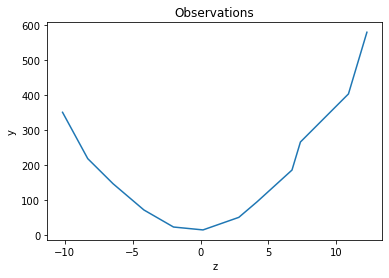

In [80]:
import matplotlib.pyplot as plt 

fig = plt.figure()
plt.plot(z,y)
plt.title("Observations")
plt.xlabel('z')
plt.ylabel('y')
plt.show()

### Modèle Stochastique

In [81]:
# Mise en place vecteur l
l = np.zeros((24,1))
for i in range(12):
    l[[j for j in range(0,24,2)][i]] = y[i]
    l[[j for j in range(0,24,2)][i]+1] = z[i]

# Matrice de variance-covariance
Kl = np.identity(24)
for i in range(24):
    if i%2 == 0:
        Kl[i,i] = sigma_y**2
    else:
        Kl[i,i] = sigma_z**2

sigma0 = 0.2

# Matrice des cofacteurs
Ql = 1/sigma0**2 * Kl

## Polynôme de degré 2

### Initialisation

In [82]:
def f(x,l):
    result = np.zeros((12,1))
    even_list = [i for i in range(0,24,2)]
    for i in range(12):
        result[i] = x[0] + x[1]*l[even_list[i]+1] + x[2]*l[even_list[i]+1]**2 - l[even_list[i]]
    return result

x0 = np.array([[1],[1],[1]])

w = f(x0,l)

# Building A
def gen_A(l):
    z = l[1:24:2]
    return np.hstack( ( np.ones((12,1)), z, z**2 ) )
A = gen_A(l)

# Building G
def gen_G(l,x):
    z = l[1:24:2]
    G = np.zeros((12,24))
    for i in range(0,12):
        G[i,2*i] = -1
        G[i,2*i+1] = x[1] + 2*x[2]*z[i]
    return G
G = gen_G(l,x0)

### Dimensions

In [83]:
n = l.shape[0]
p = x0.shape[0]
r = A.shape[0]
print('n',n)
print('p',p)
print('r',r)

n 24
p 3
r 12


### Matrice de calcul

In [84]:
# Raccourci pour calcul matrice inverse
I = lambda M : np.linalg.inv(M)

S = Ql @ G.T @ I(G @ Ql @ G.T)

### Paramètres et leurs cofacteurs

In [85]:
dx_ = - I(A.T @ I(G @ Ql @ G.T) @ A) @ A.T @ I(G @ Ql @ G.T) @ w
x_ = x0 + dx_

# Iterations
for k in range(5):
    A = gen_A(l)
    G = gen_G(l,x_)
    S = Ql @ G.T @ I(G @ Ql @ G.T)
    dx_ = - I(A.T @ I(G @ Ql @ G.T) @ A) @ A.T @ I(G @ Ql @ G.T) @ w
    x_ = x0 + dx_

Qx_ = I(A.T @ I(G @ Ql @ G.T) @ A)

print('dx_\n',dx_)
print('x_\n',x_)
print('Qx_\n',Qx_)

dx_
 [[13.66362562]
 [ 1.78790887]
 [ 2.48593173]]
x_
 [[14.66362562]
 [ 2.78790887]
 [ 3.48593173]]
Qx_
 [[62.45146243  1.08292959 -1.15011618]
 [ 1.08292959 17.09993958 -0.13482998]
 [-1.15011618 -0.13482998  0.33375797]]


### Observations compensées et leurs cofacteurs

In [86]:
v_ = S @ (A @ dx_ + w)
l_ = l - v_
Qv_ = S @ G @ Ql - S @ A @Qx_ @ A.T @ S.T
Ql_ = Ql - Qv_

print('v_\n',v_, '\nv_ moyen:', np.mean(v_))

v_
 [[ 0.00189053]
 [ 0.05723937]
 [-0.01034481]
 [-0.25368305]
 [ 0.00638731]
 [ 0.11978202]
 [ 0.02590654]
 [ 0.30304458]
 [ 0.00164239]
 [ 0.00812283]
 [-0.0559948 ]
 [ 0.10043906]
 [ 0.00239148]
 [-0.02383045]
 [ 0.01886144]
 [-0.26708286]
 [-0.00517444]
 [ 0.11438144]
 [ 0.03243605]
 [-0.77951655]
 [-0.02010654]
 [ 0.70363402]
 [ 0.00210486]
 [-0.08253042]] 
v_ moyen: -8.326672684688674e-17


### Erreur moyenne quadratique

In [87]:
sigma0_2_ = v_.T @ I(Ql) @ v_ / (r-p)
sigma0_2 = sigma0**2
print(float(sigma0_2_/sigma0_2))
print('< 2 ? :', float(sigma0_2_/sigma0_2) < 2)
sigma0_2_, sigma0_2

0.9590928280858514
< 2 ? : True


(array([[0.03836371]]), 0.04000000000000001)

### Test du Khi-carré
On effectue le test du khi-carré avec alpha=5.

In [88]:
# Intervalle de confiance à 95% [a,b]
from scipy.stats import chi2
alpha = 0.05
deg_lib = r-p
a, b = chi2.interval(1-alpha/2, deg_lib)

print('L\'intervalle obtenu est [{},{}]'.format(a,b))
print('{} dans l\'intervalle ? : {}'.format(deg_lib*sigma0_2/sigma0**2, a < deg_lib*sigma0_2/sigma0**2 < b))

L'intervalle obtenu est [2.2195922831967065,21.03407043468791]
9.0 dans l'intervalle ? : True


sigma0_**2 suit la loi du khi-2. C'est bon signe pour la qualité de l'estimation.

### Corrélation entre les paramètres 

In [97]:
rho = lambda X,Y : sigma0**2*Qx_[i,j]/np.sqrt(sigma0**2*Qx_[i,i] * sigma0**2*Qx_[j,j])
rhos_deg2 = []
for i in range(3):
    for j in range(3):
        if i != j:
            print('rho({},{}):{}'.format(i,j,rho(i,j)))
            rhos_deg2.append(rho(i,j))
print('mean rho:',np.mean(rhos_deg2),'var rho:',np.var(rhos_deg2), 'min rho:',np.min(rhos_deg2),'max rho:',np.max(rhos_deg2))

rho(0,1):0.033138406859964394
rho(0,2):-0.2519153244703957
rho(1,0):0.03313840685996438
rho(1,2):-0.05643822568942469
rho(2,0):-0.2519153244703961
rho(2,1):-0.056438225689424686
mean rho: -0.09173838109995207 var rho: 0.014165655443563898 min rho: -0.2519153244703961 max rho: 0.033138406859964394


### Aperçu du résultat

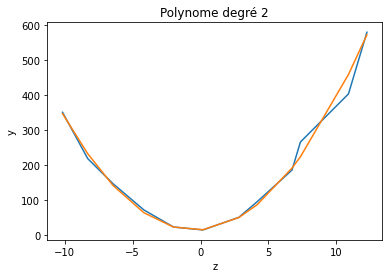

In [90]:
pol_d2 = lambda x,z : x[0] + x[1]*z + x[2]*z**2

fig_res = plt.figure()
plt.plot(z,y)
plt.plot(z,pol_d2(x_,z))
plt.title("Polynome degré 2")
plt.xlabel('z')
plt.ylabel('y')
plt.show()

## Polynôme de degré 3

### Initialisation

In [91]:
def f(x,l):
    result = np.zeros((12,1))
    for i in range(12):
        result[i] = x[0] + x[1]*l[2*i+1] + x[2]*l[2*i+1]**2 + x[3]*l[2*i+1]**3 - l[2*i]
    return result

x0 = np.array([[1],[1],[1],[1]])

w = f(x0,l)

# Building A
def gen_A_deg3(l):
    z = l[1:24:2]
    return np.hstack( ( np.ones((12,1)), z, z**2, z**3 ) )

# Building G
def gen_G_deg3(l,x):
    z = l[1:24:2]
    G = np.zeros((12,24))
    for i in range(0,12):
        G[i,2*i] = -1
        G[i,2*i+1] = x[1] + 2*x[2]*z[i] + 3*x[3]*z[i]**2
    return G


### Dimensions

In [92]:
n = l.shape[0]
p = x0.shape[0]
r = A.shape[0]
print('n',n)
print('p',p)
print('r',r)
G.shape, A.shape

n 24
p 4
r 12


((12, 24), (12, 3))

### Matrice de Calcul

In [93]:
S = Ql @ G.T @ I(G @ Ql @ G.T)
S.shape, w.shape

((24, 12), (12, 1))

### Paramètres et leurs cofacteurs

In [94]:
# Initial iteration
A = gen_A_deg3(l)
G = gen_G_deg3(l,x_)
dx_ = - I(A.T @ I(G @ Ql @ G.T) @ A) @ A.T @ I(G @ Ql @ G.T) @ w
x_ = x0 + dx_

# Iterations
for k in range(5):
    A = gen_A_deg3(l)
    G = gen_G_deg3(l,x_)
    S = Ql @ G.T @ I(G @ Ql @ G.T)
    dx_ = - I(A.T @ I(G @ Ql @ G.T) @ A) @ A.T @ I(G @ Ql @ G.T) @ w
    x_ = x0 + dx_

Qx_ = I(A.T @ I(G @ Ql @ G.T) @ A)

print('dx_\n',dx_)
print('x_\n',x_)
print('Qx_\n',Qx_)

IndexError: index 3 is out of bounds for axis 0 with size 3

### Observations compensées et leurs cofacteurs

In [66]:
v_ = S @ (A @ dx_ + w)
l_ = l - v_
Qv_ = S @ G @ Ql - S @ A @Qx_ @ A.T @ S.T
Ql_ = Ql - Qv_

print('v_\n',v_, '\nv_ moyen:', np.mean(v_))

v_
 [[-0.00133652]
 [-0.04215581]
 [-0.0115246 ]
 [-0.29176848]
 [ 0.0059603 ]
 [ 0.11422794]
 [ 0.02893575]
 [ 0.34035262]
 [ 0.01674543]
 [ 0.08043111]
 [-0.06115951]
 [ 0.12364455]
 [-0.00383611]
 [ 0.03887243]
 [ 0.01473716]
 [-0.20969428]
 [-0.00655737]
 [ 0.14331585]
 [ 0.03266199]
 [-0.77344964]
 [-0.01963411]
 [ 0.66502153]
 [ 0.00500759]
 [-0.18879781]] v_ moyen: 9.159339953157541e-16


### Erreur moyenne quadratique

In [62]:
sigma0_2_ = v_.T @ I(Ql) @ v_ / (r-p)
sigma0_2 = sigma0**2
print(float(sigma0_2_/sigma0_2))
print('< 2 ? :', float(sigma0_2_/sigma0_2) < 2)
sigma0_2_, sigma0_2

1.080241718642337
< 2 ? : True


(array([[0.04320967]]), 0.04000000000000001)

### Test du khi-carré

In [63]:
# Intervalle de confiance à 95% [a,b]
from scipy.stats import chi2
alpha = 0.05
deg_lib = r-p
a, b = chi2.interval(1-alpha/2, deg_lib)

print('L\'intervalle obtenu est [{},{}]'.format(a,b))
print('{} dans l\'intervalle ? : {}'.format(deg_lib*sigma0_2/sigma0**2, a < deg_lib*sigma0_2/sigma0**2 < b))

L'intervalle obtenu est [1.7602677285872679,19.478458481466028]
8.0 dans l'intervalle ? : True


### Corrélation entre les paramètres

In [77]:
rho = lambda X,Y : sigma0**2*Qx_[i,j]/np.sqrt(sigma0**2*Qx_[i,i] * sigma0**2*Qx_[j,j])
rhos = []
for i in range(4):
    for j in range(4):
        if i != j:
            print('rho({},{}):{}'.format(i,j,rho(i,j)))
            rhos.append(rho(i,j))
print('mean rho:',np.mean(rhos),'var rho:',np.var(rhos), 'min rho:',np.min(rhos),'max rho:',np.max(rhos))

rho(0,1):0.021240825266828873
rho(0,2):-0.2668109690043213
rho(0,3):0.026661990892552778
rho(1,0):0.021240825266828498
rho(1,2):0.20970354071898475
rho(1,3):-0.7727721544397007
rho(2,0):-0.26681096900432183
rho(2,1):0.20970354071898453
rho(2,3):-0.3519405812361688
rho(3,0):0.026661990892552983
rho(3,1):-0.7727721544397007
rho(3,2):-0.3519405812361689
mean rho: -0.18898622463363748 var rho: 0.10384498656300822 min rho: -0.7727721544397007 max rho: 0.20970354071898475


### Aperçu du résultat

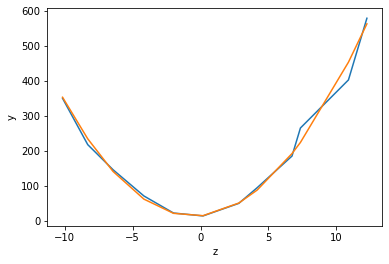

In [64]:
pol_d2 = lambda x,z : x[0] + x[1]*z + x[2]*z**2 + x[3]*z**3

fig_res = plt.figure()
plt.plot(z,y)
plt.plot(z,pol_d2(x_,z))
plt.title("Polynome degré 3")
plt.xlabel('z')
plt.ylabel('y')
plt.show()